# Проект 2. Разведывательный анализ данных EDA

### Цель проекта: Проведение разведывательного анализа предложенных данных из dataset для его подготовки к обучению и тестированию ML-модели

### Задачи проекта:

1. Провести первичную обработку данных (первичный осмотр данных)
2. Посмотреть на распределенные признака для числовых переменных, устранить выбросы
3. Оценить количество уникальных значений для номинативных переменных
4. По необходимости преобразовать данные
5. Провести корреляционный анализ количественных переменных
6. Отобрать не коррелирующие переменные
7. Проанализировать номинативные переменные и устранить те, которые не влияют на предсказываемую величину
8. Сформулировать выводы относительно качества данных и тех переменных, которые будут использоваться в дальнейшем построении модели

### Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
import random
import warnings
warnings.simplefilter('ignore')
import pandas_profiling

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

### Загрузка dataset

In [50]:
stud = pd.read_csv('/home/vyper/GIT/DS/module_2/stud_math.csv')

### Описание данных dataset

#### Словарь значений полей


school — аббревиатура школы, в которой учится ученик \
sex — пол ученика ('F' - женский, 'M' - мужской) \
age — возраст ученика (от 15 до 22) \
address — тип адреса ученика ('U' - городской, 'R' - за городом) \
famsize — размер семьи('LE3' <= 3, 'GT3' >3) \
Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно) \
Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее) \
Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее) \
Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое) \
Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое) \
reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое) \
guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое) \
traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.) \
studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов) \
failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0) \
schoolsup — дополнительная образовательная поддержка (yes или no) \
famsup — семейная образовательная поддержка (yes или no) \
paid — дополнительные платные занятия по математике (yes или no) \
activities — дополнительные внеучебные занятия (yes или no) \
nursery — посещал детский сад (yes или no) \
higher — хочет получить высшее образование (yes или no) \
internet — наличие интернета дома (yes или no) \
romantic — в романтических отношениях (yes или no) \
famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо) \
freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого) \
goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много) \
health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо) \
absences — количество пропущенных занятий \
score — баллы по госэкзамену по математике

In [51]:
# Функции


def get_boxplot(df: pd.DataFrame, column: object, ax_y = 'score') -> None:
    ''' Отображение boxplot-графиков для номинативных и смешанных переменных '''
    
    fig, ax = plt.subplots(figsize = (8, 4))
    box_plot = sns.boxplot(x=column, y=ax_y, data=df, ax=ax)
    cnt = df[column].value_counts()
    median = stud.groupby([column])[ax_y].median()
    vertical_offset = stud.groupby([column])[ax_y].median()*0.12
    x = stud[column].unique()
    x = list(filter(lambda v: v==v, x))
    if df.loc[:, col].dtypes!=np.dtype('O'):
        x = sorted(x)
    for xtick, ytick in zip(list(box_plot.get_xticks()), x):
        box_plot.text(xtick, median.loc[ytick] - vertical_offset[ytick], cnt.loc[ytick],
                     horizontalalignment='center', size=15, color='w', weight='semibold')
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    

def get_stat_tstud(df: pd.DataFrame, column: object, target = 'score') -> bool:
    ''' Тест Стьюдента для номинативных и смешанных переменных '''
    
    cols = df.loc[:, column].value_counts()
    cols = cols[cols>15].index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], target].dropna(),
                    df.loc[df.loc[:, column] == comb[1], target].dropna()).pvalue \
            <= 0.075/len(combinations_all): # Поправка Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            return True
            break

### 1. Первичный осмотр данных

In [54]:
display(stud.head(10))
stud.info()
stud.shape

school sex  age address famsize Pstatus  Medu  Fedu      Mjob     Fjob  \
0     GP   F   18       U     NaN       A   4.0   4.0   at_home  teacher   
1     GP   F   17       U     GT3     NaN   1.0   1.0   at_home    other   
2     GP   F   15       U     LE3       T   1.0   1.0   at_home    other   
3     GP   F   15       U     GT3       T   4.0   2.0    health      NaN   
4     GP   F   16       U     GT3       T   3.0   3.0     other    other   
5     GP   M   16       U     LE3       T   4.0   3.0  services    other   
6     GP   M   16     NaN     LE3       T   2.0   2.0     other    other   
7     GP   F   17       U     GT3       A   4.0   4.0     other  teacher   
8     GP   M   15       U     LE3       A   3.0   2.0  services    other   
9     GP   M   15       U     NaN     NaN   3.0   4.0     other    other   

       reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0      course   mother         2.0        2.0       0.0       yes     no   no   
1      course   father         1.0        2.0       0.0        no    yes   no   
2       other   mother         1.0        2.0       3.0       yes     no  NaN   
3        home   mother         1.0        3.0       0.0        no    yes  yes   
4        home   father         1.0        2.0       0.0        no    yes  yes   
5  reputation   mother         1.0        2.0       0.0        no    yes  yes   
6        home   mother         1.0        2.0       0.0        no     no   no   
7        home   mother         2.0        2.0       0.0       yes    yes   no   
8        home   mother         1.0        2.0       0.0        no    yes  yes   
9        home   mother         1.0        2.0       0.0        no    yes  yes   

  activities nursery  studytime, granular higher internet romantic  famrel  \
0         no     yes                 -6.0    yes      NaN       no     4.0   
1         no      no                 -6.0    yes      yes       no     5.0   
2         no     yes                 -6.0    yes      yes      NaN     4.0   
3        yes     yes                 -9.0    yes      yes      yes     3.0   
4         no     yes                 -6.0    yes       no       no     4.0   
5        yes     yes                 -6.0    yes      yes       no     5.0   
6         no     yes                 -6.0    yes      yes       no     4.0   
7         no     yes                 -6.0    yes       no       no     4.0   
8         no     yes                 -6.0    yes      yes       no     NaN   
9        yes     yes                 -6.0    yes      yes       no     5.0   

   freetime  goout  health  absences  score  
0       3.0    4.0     3.0       6.0   30.0  
1       3.0    3.0     3.0       4.0   30.0  
2       3.0    2.0     3.0      10.0   50.0  
3       2.0    2.0     5.0       2.0   75.0  
4       3.0    2.0     5.0       4.0   50.0  
5       4.0    2.0     5.0      10.0   75.0  
6       4.0    4.0     3.0       0.0   55.0  
7       1.0    4.0     1.0       6.0   30.0  
8       2.0    2.0     1.0       0.0   95.0  
9       5.0    1.0     5.0       0.0   75.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

(395, 30)

In [55]:
stud.isnull().values.any()

True

В dataset содержится информация о 395 школьниках. Все столбцы, кроме первых трех (school, sex, age), содержат пропуски в значениях. Данные представлены в 30 столбцах. 17 столбцов содержат строковый тип, 13 стобцов содержат числовой тип.

У нас есть 3 переменных, которые более показательны на первый взгляд: age, absences, score (количественные переменные)

In [41]:
stud.describe().T.style.bar(
    subset=['mean'],
    color='#606ff2').background_gradient(
    subset=['std'], cmap='PuBu').background_gradient(subset=['50%'], cmap='PuBu')

Помимо score, age, adsences также стоит обратить внимание на переменные failures, studytime, Medu, Fedu, goout

### 2 Просмотр распределенныя признака для числовых переменных, устранение выбросов

In [7]:
# Проверка на дубликаты в dataset
if len(stud) > len(stud.drop_duplicates()):
    print('Дубликаты имеются')
else:
    print('Дубликаты отсутствуют')


Дубликаты отсутствуют


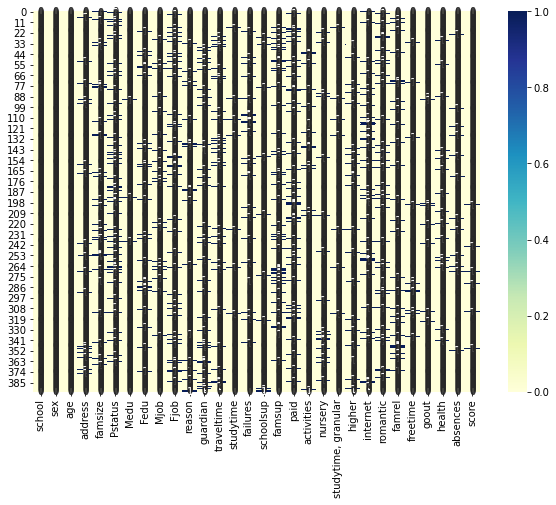

In [8]:
# Проверка распределения пропусков по dataset
plt.figure(figsize=(10, 7))
sns.heatmap(stud.isnull(),cmap="YlGnBu", annot=True)

Пропуски распределены равномерно по всему dataset следовательно очистка в виде удаления нам не подходит.

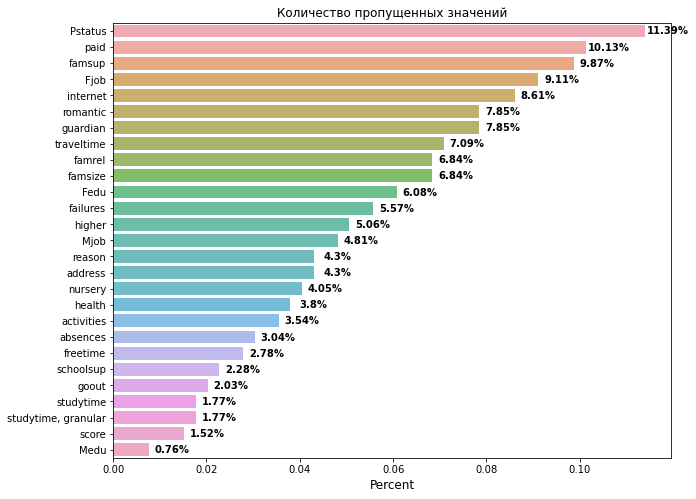

In [56]:
# Посчитаем возможный процент пропусков в строках
per_nans = pd.DataFrame(1-stud.count()/stud.shape[0]).reset_index().rename({0:'percent'},
                                            axis=1).sort_values('percent', ascending = False).query('percent>0')
# Построим график для количества пропущенных значений
fig, ax = plt.subplots(figsize = (10, 8))
bar_plot = sns.barplot(x='percent', y='index', data=per_nans, alpha=0.8, ci=None)
for ytick in bar_plot.get_yticks():
        bar_plot.text(per_nans.iloc[ytick][1] + 0.005, ytick+0.2, str(round(per_nans.iloc[ytick][1]*100,2)) + '%',
                    horizontalalignment = 'center', size=10, color='black', weight='semibold')
plt.title('Количество пропущенных значений')
plt.ylabel('')
plt.xlabel('Percent', fontsize=12)
plt.show()

### 3 Оценка количества уникальных значений для номинативных переменных

In [14]:
#Воспользуемся библиотекой pandas_profiling и выгрузим данные для просмотра в html
pfr = pandas_profiling.ProfileReport(stud)
pfr.to_file("eda_stud.html")

Summarize dataset:   0%|          | 0/43 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
pfr

#### Выводы от сбора статистики и графиков

school - Приимущественно GP перед MS (ошибок нет, пропусков нет) 

sex - пол учеников распределен практически равномерно (ошибок нет, пропусков нет)

age - возраст учеников в разбеге от 15 до 22. Основная категория от 15 до 18 лет. Есть небольшое количество учеников возростных от 20 до 22 лет (ошибок нет, пропусков нет)

address - большинство учеников живут в городе (ошибок нет, процент пропусков 4.3%)

famsize - численность семьи у которой больше 3 человек преобладает(ошибок нет, процент пропусков 6.8%)

Pstatus - большинство родителей живут вместе (ошибок нет, процент пропусков 11.4%)

Medu — большинство матерей имеют высшее образование, соотношение образования между средним и среднеспециальным одинаковое (ошибок нет, процент пропусков 0.8%)

Fedu — ДО исправления - Есть аномалия - один выброс значения 40. Возможно ошибка. ПОСЛЕ исправления- большинство отцов имеют среднее образование, остальное соотношение примерно одинаковое (ошибок 1 строка, процент пропусков 6.1%) 

Mjob — большинство попадают под категорию другое либо гос. служба (ошибок нет, процент пропусков 4.8%)

Fjob — большинство попадают под категорию другое либо гос. служба (ошибок нет, процент пропусков 9.1%)

reason — выбирают школу согласно образовательной программе, а близость к дому и репутацию оставлют на второй план (ошибок нет, процент пропусков 4.3%)

guardian — опекуном по большей части для ученика является его мать (ошибок нет, процент пропусков 7.8%)

traveltime — большинство учеников делять время в пути до школы между меньше 15 мин и от 15 до 30 мин. (ошибок нет, процент пропусков 7.1%)

studytime — большинство учеников тратят время на учёбу в неделю, помимо школы, либо меньше 2 часов либо от 2 до 5 часов (ошибок нет, процент пропусков 1.8%)

failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0) (ошибок нет, процент пропусков 5.6%)

schoolsup — дополнительная образовательная поддержка больше отсутствует (ошибок нет, процент пропусков 2.3%)

famsup — семейная образовательная поддержка больше присутствует чем нет (ошибок нет, процент пропусков 9.9%)

paid — дополнительные платные занятия по математике в большинстве случаев отвутствуют у учеников (ошибок нет, процент пропусков 10.1%)

activities — а вот дополнительные внеучебные занятия все же больше присутствуют, но процент их отсутствия, можно сказать, одинаковый  (ошибок нет, процент пропусков 3.5%)

nursery — большинство учеников в детский сад ходили перед школой (ошибок нет, процент пропусков 4.1%)

higher — 356 учеников хотят получить высшее образование (ошибок нет, процент пропусков 5.1%)

internet — у 305 учеников дома есть интернет (ошибок нет, процент пропусков 8.6%)

romantic — 240 учеников состоят в романтичных отношениях с противоположенным полом (ошибок нет, процент пропусков 7.8%)

famrel — 25 строка содержит выброс. Возможно "-1" поставил ученик случайно. В основном ученики из благополучных семей (ошибок 1 строка, процент пропусков 6.8%)

freetime — большинство учеников проставили среднее значение "3" по свободному времени после школы (ошибок нет, процент пропусков 2.8%)

goout — также большинство учеников проставили среднее значение "3" по проведению времени с друзьями (ошибок нет, процент пропусков 2.0%)

health — 138 учеников не жалуется на здоровье вовсе (ошибок нет, процент пропусков 3.8%)

absences — количество пропущенных занятий (ошибки в 17 строках, процент пропусков 3.0%) Два значения, 385 и 212, выбиваются из общей массы. Явно нужно обработать эту переменную, так как эти значения будут негативно влиять на ML. Возможно их будет лучше заменить на медиану.

score — 54 ученика набрали 50 баллов по госэкзамену по математике. В основном идет логичное распределение баллов между количеством учеников. 0 баллов получили 37 учеников. Возможно это порог проходной, если он не набран, то проставляется 0. Надо оставить 0е значения (провал на графике), так как это могут быть склонные к провалу экзамена ученики. (ошибок нет, процент пропусков 1.5%)


#### Промежуточный вывод

- в переменных Fedu, famrel обнаружены ошибки: значения недопустимы по условию задания
- в переменных Adsences, famrel, "studytime, granular" есть выбросы
- переменная score содержит 1.5% пропусков
- распределение studytime совпадает со "studytime, granular"

### 4 Преобразование интересующих нас переменных

In [58]:
# Код преобразования для переменных
stud.Fedu = stud.Fedu.replace(40,4)
stud.famrel = stud.famrel.replace(-1,1)
stud.absences = stud.absences.apply(lambda x: stud.absences.median() if x>100 else x)
stud.dropna(subset=['score'], inplace=True)

### 5 Провести корреляционный анализ количественных переменных

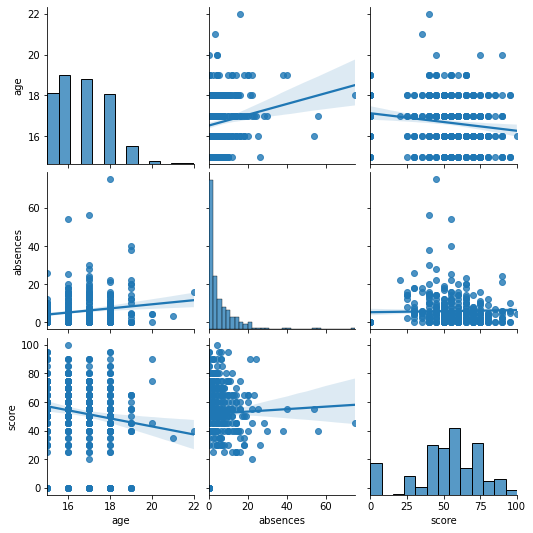

In [59]:
stud_num = ['age', 'absences', 'score']
sns.pairplot(stud[stud_num], kind='reg');

In [60]:
stud[stud_num].corr()

age  absences     score
age       1.000000  0.169071 -0.155726
absences  0.169071  1.000000  0.030943
score    -0.155726  0.030943  1.000000

Линейная связь absences со score незначительна. Проверим также на нелинейной зависимости

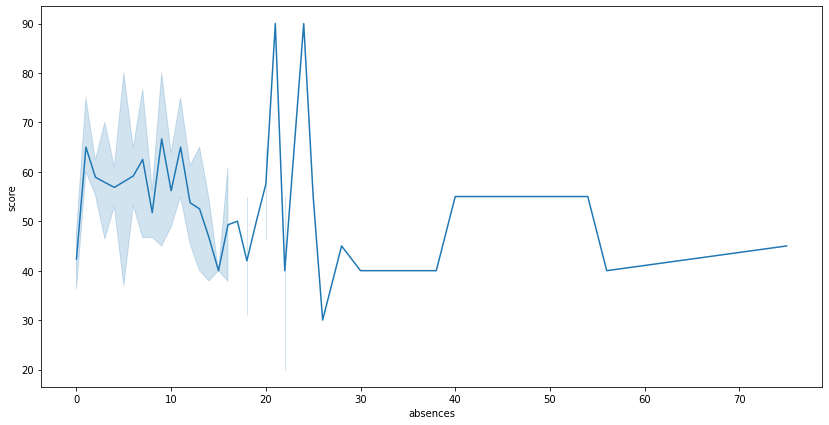

In [61]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stud, x='absences', y='score')

У зависомости между absences и score низкая значимость

##### Высокую корреляцию имеют переменные:

studytime - studytime, granular. Следовательно studytime, granular аналогичную информацию и ее можно удалить.\
Medu - Fedu. Можно сгенерировать доп. переменную на основе этих двух переменных и восстановить пропуски по значениям.

In [63]:
# Код преобразования для переменных на основе проведенной корреляции:
stud.drop('studytime, granular', axis=1, inplace=True)
stud['Pedu'] = stud['Fedu'] + stud['Medu']

### 6 Отобрать не коррелирующие переменные

In [68]:
# Сортировка по корреляции переменных
score_corr = pd.DataFrame(stud.corr()['score'].values, index=stud.corr()['score'].index, columns=['correlation'])
score_corr = score_corr.drop('score')

score_corr['correlation_sum'] = abs(score_corr.correlation)
printmd('##### Коррелирующие значения в порядке убывания')
score_corr.sort_values(by='correlation_sum', ascending=False)

##### Коррелирующие значения в порядке убывания

correlation  correlation_sum
failures     -0.344338         0.344338
Medu          0.213349         0.213349
Pedu          0.186997         0.186997
age          -0.155726         0.155726
Fedu          0.130923         0.130923
goout        -0.129685         0.129685
studytime     0.115741         0.115741

#### Промежуточный вывод

Больше всего в обучении учеников мешают проблемы вне школы, юный возраст учеников и активное общение с друзьями.
Но на результат позитивно сказывается образование родителей и самообучение.\

Вычистим столбцы со значениями корреляции ниже 0.1

In [70]:
# Код преобразования на основе коррелирующих значений переменных
stud.drop(score_corr[score_corr.correlation_sum < 0.1].index, axis=1, inplace=True)

### 7 Проанализировать номинативные переменные и устранить те, которые не влияют на предсказываемую величину

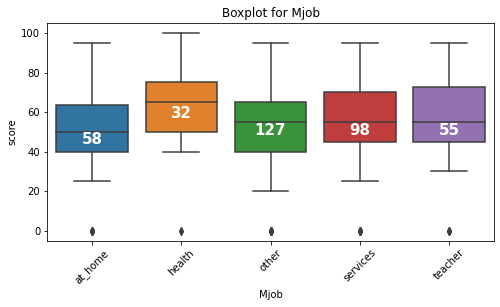

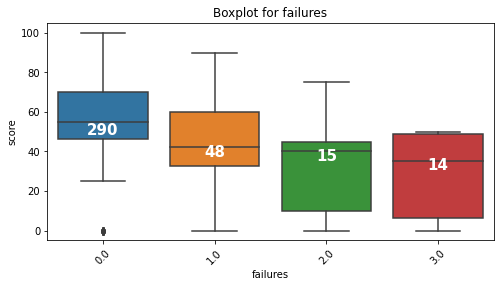

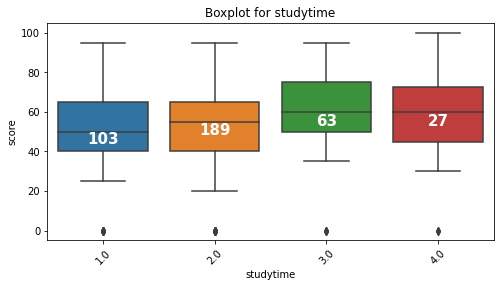

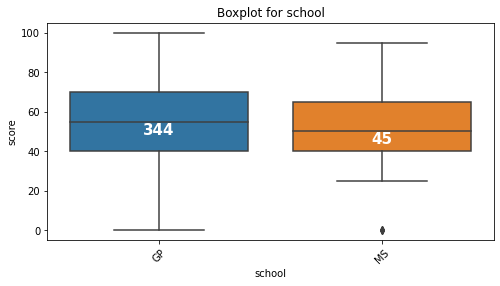

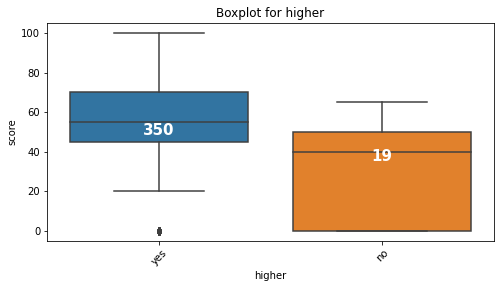

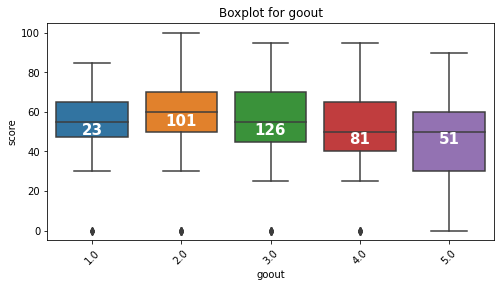

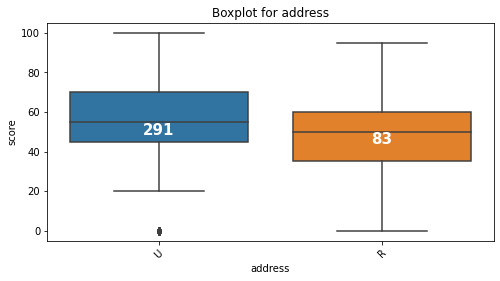

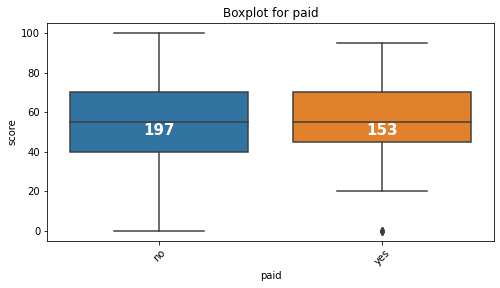

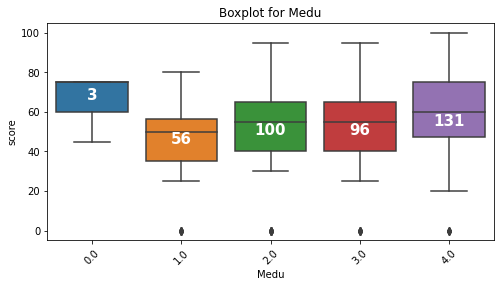

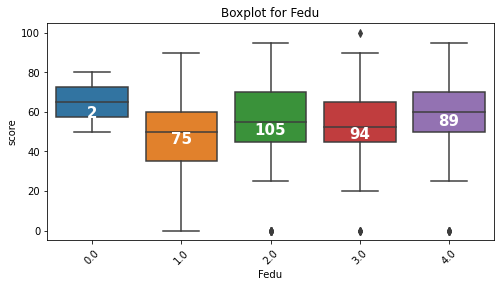

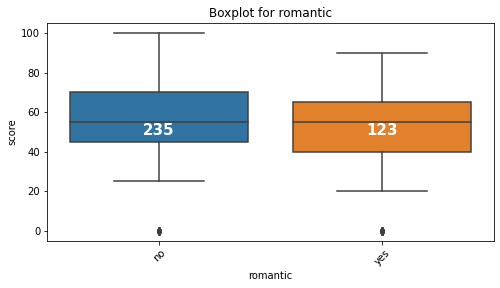

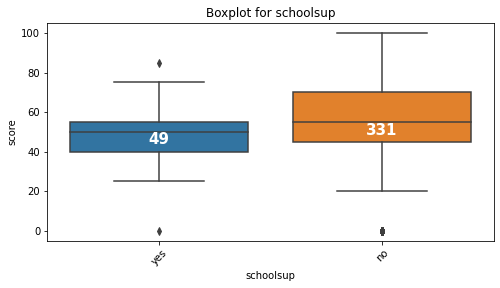

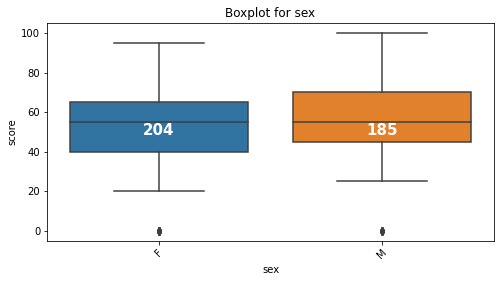

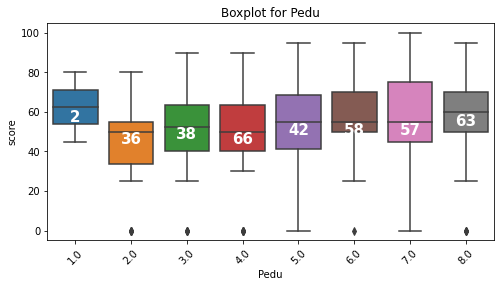

In [71]:
# Запустим функцию get_boxplot для формирования вывода по визуальному анализу за вычетом показательных переменных
nomin_cols = list(set(stud.columns) - set(['age', 'adsences', 'score']))
for col in nomin_cols:
    get_boxplot(stud, col)

#### Промежуточный вывод

После просмотра выводов boxplot значимыми для моделирования предикторами являются:

- schoolsup
- Fedu
- Pedu
- failures
- Mjob
- Medu
- higher
- goout
- school
- address
- studytime

#### Тест Стьюдента для номинативных и смешанных переменных

C помощью теста Стьюдента проверим имеется ли разница в распределении оценок по номинативным признакам

In [72]:
nomin_cols = list(set(stud.columns) - set(['age', 'absences', 'score']))
lst = []
for col in nomin_cols:
    if get_stat_tstud(stud, col):
        lst.append(col)

Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки goout
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Fedu
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки Pedu


Тест Стьюдента и boxplot графики показали взаимодополняемость, а не взаимоисключаемость. Следовательно на этапе EDA мы оставляем признаки, которые показались нам информативными.

In [73]:
list_columns = set(['schoolsup', 'Fedu', 'Pedu', 'failures', 'Mjob', 'Medu', \
                   'higher', 'goout', 'school', 'address', 'studytime', 'age', 'score'] + lst)
stud = stud[list_columns]

In [74]:
stud.head()

Mjob paid  failures  studytime address  Medu  Fedu school higher  age  \
0  at_home   no       0.0        2.0       U   4.0   4.0     GP    yes   18   
1  at_home   no       0.0        2.0       U   1.0   1.0     GP    yes   17   
2  at_home  NaN       3.0        2.0       U   1.0   1.0     GP    yes   15   
3   health  yes       0.0        3.0       U   4.0   2.0     GP    yes   15   
4    other  yes       0.0        2.0       U   3.0   3.0     GP    yes   16   

  romantic  goout  score schoolsup sex  Pedu  
0       no    4.0   30.0       yes   F   8.0  
1       no    3.0   30.0        no   F   2.0  
2      NaN    2.0   50.0       yes   F   2.0  
3      yes    2.0   75.0        no   F   6.0  
4       no    2.0   50.0        no   F   6.0

### 8 Сформулировать выводы относительно качества данных и тех переменных, которые будут использоваться в дальнейшем построении модели

1. Данные чистые:
   - количество пропущенных значений распределено от 1% до 11%. Есть три переменные, в которых данные 100% заполнены
   - ошибки обнаружены в переменных Fedu, famrel и заменены
   - переменная absences содержала 2 аномальных значения (>200), которые были заменены на медиану

2. После подробного осмотра распределений было принято решение:
   - удалить пропуски из целевой переменной за ненадобностью
   - оставить 0 значение в score для выявления возможности моделирования этих случаев

3. В результате корреляции:
   - обнаружена сильная обратная корреляция между studytime и studytime, granular. Поэтому один из них был удален за ненадобностью
   - обнаружена линейная зависимость между Fedu, Medu, которая была использована для создания нового признака Pedu
   - исключены переменные с коэффициентом корреляции 0.1 по модулю, как самые бесперспективные
4. Анализ номинативных и смешанных переменных  помощью boxplot и теста Стьюдента позволил выделить значимые признаки, а именно: goout, sex, paid, Mjob, failures, Medu, Fedu, address, romantic, schoolsup, school, studytime, higher, Pedu

#### Итоговый ответ:
Для дальнейшего обучения ML-модели рекомендуется использовать параметры: goout, sex, paid, Mjob, failures, Medu, Fedu, address, romantic, schoolsup, school, studytime, higher, Pedu